# TinyML Demo Using ESP8266 Microcontrollers Version 1.0

In this notebook we will be attempting to create a model which will be converted to a Tensorflow lite model to run on a ESP8622 D1 Mini microcontroller.  The model will try to determine if the victim microcontroller is being attacked by being flooded with requests to put its LED light to 100%.
The goal of this notebook is to learn more about using TinyML models and see how this can eventually be applied to a SCADA like enviroment.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
import matplotlib.pyplot as plt

MODEL_NO_QUANT_TFLITE = 'model_no_quant.tflite'
MODEL_TFLITE = 'model.tflite'
MODEL_TFLITE_MICRO = 'model.cc'

In [2]:
#The data processing for the training and testing data sets
def data_train(filename, split = True):
    train_data = pd.read_excel(filename)
    train_data['Data'] = train_data['Data'] / 1000000
    #train_data['Data'] = train_data['Data'] / 10000000
    
    tmp = train_data[['Data']].copy()

    X = pd.DataFrame(tmp).to_numpy()
    X = np.float32(X)
    
    if split == True:
        m = X.shape[0]
        Y = np.array([train_data['Active Attack'].values])
        Y = np.float32(Y)
        Y = Y.T
        
        #Shuffle (X, Y)
        permutation = list(np.random.permutation(m))
        shuff_X = X[permutation, :]
        shuff_Y = Y[permutation, :]
    
        devM = round(m * .3) # 30% of the set
        devM2 = m - devM # 70% of the set
        devM3 = round(devM / 2) #15% of the set
        
        train_X = shuff_X[0:(devM2), :]
        train_Y = shuff_Y[0:(devM2), :]
        dev_X = shuff_X[-(devM):-(devM3), :]
        dev_Y = shuff_Y[-(devM):-(devM3), :]
        test_X = shuff_X[-(devM3):, :]
        test_Y = shuff_Y[-(devM3):, :]
        
        m_train = train_X.shape[0]
        m_dev = dev_X.shape[0]
        m_test = test_X.shape[0]
        
        print ("Number of training examples: m_train = " + str(m_train))
        print ("train_set_x shape: " + str(train_X.shape))
        print ("train_set_y shape: " + str(train_Y.shape))
        print ("Number of dev examples: m_test = " + str(m_dev))
        print ("test_set_x shape: " + str(dev_X.shape))
        print ("test_set_y shape: " + str(dev_Y.shape))       
        print ("Number of testing examples: m_train = " + str(m_test))
        print ("train_set_x shape: " + str(test_X.shape))
        print ("train_set_y shape: " + str(test_Y.shape))
    
        return train_X, train_Y, dev_X, dev_Y, test_X, test_Y
    
    return X
    
train_X, train_Y, dev_X, dev_Y, test_X, test_Y = data_train("PuttyData.xlsx", split = True)

Number of training examples: m_train = 910
train_set_x shape: (910, 1)
train_set_y shape: (910, 1)
Number of dev examples: m_test = 195
test_set_x shape: (195, 1)
test_set_y shape: (195, 1)
Number of testing examples: m_train = 195
train_set_x shape: (195, 1)
train_set_y shape: (195, 1)


In [3]:
model = tf.keras.Sequential()
model.add(keras.layers.Dense(64, activation='relu', input_shape=(1,)))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(train_X, train_Y, epochs=400, batch_size=64,
                    validation_data=(dev_X, dev_Y))

Train on 910 samples, validate on 195 samples
Epoch 1/400
910/910 [==============================] - 1s 868us/sample - loss: 0.4491 - mae: 0.5752 - val_loss: 0.2431 - val_mae: 0.3349
Epoch 2/400
910/910 [==============================] - 0s 84us/sample - loss: 0.2295 - mae: 0.3264 - val_loss: 0.2326 - val_mae: 0.3404
Epoch 3/400
910/910 [==============================] - 0s 85us/sample - loss: 0.2145 - mae: 0.2949 - val_loss: 0.2148 - val_mae: 0.3003
Epoch 4/400
910/910 [==============================] - 0s 88us/sample - loss: 0.1875 - mae: 0.2753 - val_loss: 0.1757 - val_mae: 0.2748
Epoch 5/400
910/910 [==============================] - 0s 89us/sample - loss: 0.1513 - mae: 0.2516 - val_loss: 0.1420 - val_mae: 0.2462
Epoch 6/400
910/910 [==============================] - 0s 88us/sample - loss: 0.1171 - mae: 0.2149 - val_loss: 0.1088 - val_mae: 0.2173
Epoch 7/400
910/910 [==============================] - 0s 87us/sample - loss: 0.0832 - mae: 0.1840 - val_loss: 0.0787 - val_mae: 0.1842
E

910/910 [==============================] - 0s 87us/sample - loss: 0.0077 - mae: 0.0184 - val_loss: 0.0155 - val_mae: 0.0246
Epoch 61/400
910/910 [==============================] - 0s 88us/sample - loss: 0.0076 - mae: 0.0147 - val_loss: 0.0152 - val_mae: 0.0279
Epoch 62/400
910/910 [==============================] - 0s 90us/sample - loss: 0.0076 - mae: 0.0189 - val_loss: 0.0152 - val_mae: 0.0269
Epoch 63/400
910/910 [==============================] - 0s 87us/sample - loss: 0.0076 - mae: 0.0182 - val_loss: 0.0150 - val_mae: 0.0264
Epoch 64/400
910/910 [==============================] - 0s 79us/sample - loss: 0.0075 - mae: 0.0162 - val_loss: 0.0150 - val_mae: 0.0267
Epoch 65/400
910/910 [==============================] - 0s 79us/sample - loss: 0.0075 - mae: 0.0184 - val_loss: 0.0148 - val_mae: 0.0289
Epoch 66/400
910/910 [==============================] - 0s 88us/sample - loss: 0.0076 - mae: 0.0150 - val_loss: 0.0148 - val_mae: 0.0263
Epoch 67/400
910/910 [==============================] 

910/910 [==============================] - 0s 90us/sample - loss: 0.0050 - mae: 0.0167 - val_loss: 0.0090 - val_mae: 0.0234
Epoch 120/400
910/910 [==============================] - 0s 91us/sample - loss: 0.0049 - mae: 0.0189 - val_loss: 0.0090 - val_mae: 0.0224
Epoch 121/400
910/910 [==============================] - 0s 78us/sample - loss: 0.0050 - mae: 0.0205 - val_loss: 0.0091 - val_mae: 0.0360
Epoch 122/400
910/910 [==============================] - 0s 86us/sample - loss: 0.0051 - mae: 0.0237 - val_loss: 0.0086 - val_mae: 0.0249
Epoch 123/400
910/910 [==============================] - 0s 80us/sample - loss: 0.0047 - mae: 0.0194 - val_loss: 0.0087 - val_mae: 0.0210
Epoch 124/400
910/910 [==============================] - 0s 98us/sample - loss: 0.0047 - mae: 0.0156 - val_loss: 0.0084 - val_mae: 0.0265
Epoch 125/400
910/910 [==============================] - 0s 97us/sample - loss: 0.0047 - mae: 0.0143 - val_loss: 0.0082 - val_mae: 0.0224
Epoch 126/400
910/910 [=========================

910/910 [==============================] - 0s 88us/sample - loss: 0.0014 - mae: 0.0072 - val_loss: 0.0015 - val_mae: 0.0118
Epoch 178/400
910/910 [==============================] - 0s 80us/sample - loss: 0.0015 - mae: 0.0085 - val_loss: 0.0014 - val_mae: 0.0140
Epoch 179/400
910/910 [==============================] - 0s 85us/sample - loss: 0.0014 - mae: 0.0096 - val_loss: 0.0013 - val_mae: 0.0072
Epoch 180/400
910/910 [==============================] - 0s 80us/sample - loss: 0.0014 - mae: 0.0087 - val_loss: 0.0014 - val_mae: 0.0098
Epoch 181/400
910/910 [==============================] - 0s 86us/sample - loss: 0.0013 - mae: 0.0072 - val_loss: 0.0012 - val_mae: 0.0098
Epoch 182/400
910/910 [==============================] - 0s 82us/sample - loss: 0.0012 - mae: 0.0068 - val_loss: 0.0011 - val_mae: 0.0079
Epoch 183/400
910/910 [==============================] - 0s 81us/sample - loss: 0.0012 - mae: 0.0064 - val_loss: 0.0010 - val_mae: 0.0118
Epoch 184/400
910/910 [=========================

Epoch 234/400
910/910 [==============================] - 0s 85us/sample - loss: 1.7392e-04 - mae: 0.0060 - val_loss: 8.1489e-05 - val_mae: 0.0077
Epoch 235/400
910/910 [==============================] - 0s 82us/sample - loss: 2.5502e-04 - mae: 0.0083 - val_loss: 9.2463e-05 - val_mae: 0.0085
Epoch 236/400
910/910 [==============================] - 0s 79us/sample - loss: 1.4302e-04 - mae: 0.0041 - val_loss: 1.6544e-05 - val_mae: 0.0037
Epoch 237/400
910/910 [==============================] - 0s 79us/sample - loss: 1.5679e-04 - mae: 0.0056 - val_loss: 8.7990e-05 - val_mae: 0.0088
Epoch 238/400
910/910 [==============================] - 0s 87us/sample - loss: 1.6681e-04 - mae: 0.0068 - val_loss: 8.2276e-05 - val_mae: 0.0074
Epoch 239/400
910/910 [==============================] - 0s 80us/sample - loss: 1.6141e-04 - mae: 0.0074 - val_loss: 7.2613e-05 - val_mae: 0.0080
Epoch 240/400
910/910 [==============================] - 0s 90us/sample - loss: 1.7474e-04 - mae: 0.0080 - val_loss: 5.0078e

910/910 [==============================] - 0s 78us/sample - loss: 5.2821e-04 - mae: 0.0167 - val_loss: 1.1349e-04 - val_mae: 0.0087
Epoch 290/400
910/910 [==============================] - 0s 86us/sample - loss: 9.1220e-05 - mae: 0.0075 - val_loss: 1.0624e-04 - val_mae: 0.0084
Epoch 291/400
910/910 [==============================] - 0s 84us/sample - loss: 7.5796e-05 - mae: 0.0067 - val_loss: 3.8684e-05 - val_mae: 0.0052
Epoch 292/400
910/910 [==============================] - 0s 101us/sample - loss: 3.5004e-05 - mae: 0.0045 - val_loss: 2.1065e-06 - val_mae: 6.4963e-04
Epoch 293/400
910/910 [==============================] - 0s 88us/sample - loss: 3.4457e-06 - mae: 0.0013 - val_loss: 1.5468e-05 - val_mae: 0.0033
Epoch 294/400
910/910 [==============================] - 0s 86us/sample - loss: 8.4106e-06 - mae: 0.0022 - val_loss: 3.2226e-06 - val_mae: 0.0011
Epoch 295/400
910/910 [==============================] - 0s 88us/sample - loss: 6.1674e-06 - mae: 0.0018 - val_loss: 3.9194e-06 - val

Epoch 344/400
910/910 [==============================] - 0s 85us/sample - loss: 1.1476e-05 - mae: 0.0025 - val_loss: 4.3229e-05 - val_mae: 0.0053
Epoch 345/400
910/910 [==============================] - 0s 96us/sample - loss: 3.4122e-05 - mae: 0.0044 - val_loss: 1.2625e-04 - val_mae: 0.0088
Epoch 346/400
910/910 [==============================] - 0s 89us/sample - loss: 2.5726e-05 - mae: 0.0035 - val_loss: 3.0693e-06 - val_mae: 0.0011
Epoch 347/400
910/910 [==============================] - 0s 80us/sample - loss: 3.4057e-06 - mae: 0.0013 - val_loss: 1.8391e-06 - val_mae: 7.7827e-04
Epoch 348/400
910/910 [==============================] - 0s 80us/sample - loss: 8.5410e-06 - mae: 0.0020 - val_loss: 4.7446e-06 - val_mae: 0.0018
Epoch 349/400
910/910 [==============================] - 0s 87us/sample - loss: 3.3960e-05 - mae: 0.0043 - val_loss: 1.8732e-06 - val_mae: 5.2276e-04
Epoch 350/400
910/910 [==============================] - 0s 82us/sample - loss: 4.5319e-05 - mae: 0.0049 - val_loss:

910/910 [==============================] - 0s 88us/sample - loss: 1.4025e-06 - mae: 6.6143e-04 - val_loss: 3.0571e-06 - val_mae: 0.0011
Epoch 400/400
910/910 [==============================] - 0s 82us/sample - loss: 2.3195e-06 - mae: 0.0011 - val_loss: 2.2977e-06 - val_mae: 0.0011


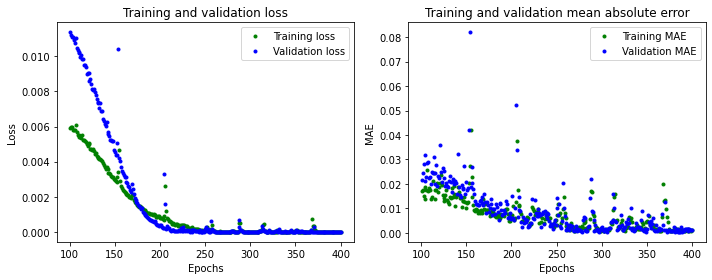

In [4]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

SKIP = 100

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)

mae = history.history['mae']
val_mae = history.history['val_mae']

plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()

195/195 [==============================] - 0s 118us/sample - loss: 1.4856e-06 - mae: 9.4150e-04


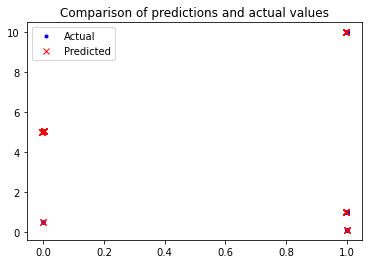

In [5]:
# Calculate and print the loss on our test dataset
loss = model.evaluate(test_X, test_Y)

# Make predictions based on our test dataset
predictions = model.predict(test_X)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(test_Y, test_X, 'b.', label='Actual')
plt.plot(predictions, test_X, 'rx', label='Predicted')
plt.legend()
plt.show()

In [6]:
# load model
#model = load_model('model.h5')
# summarize model.
#model.summary()

model.save("model_TinyML.h5")
print("Saved model to disk")

Saved model to disk


In [7]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(train_X.shape[0]):
    yield([train_X[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce full-int8 quantization (except inputs/outputs which are always float)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

import os
model_size = os.path.getsize(MODEL_TFLITE)
print("Quantized model is %d bytes" % model_size)

Quantized model is 6360 bytes


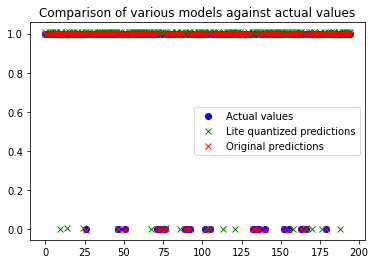

In [8]:
# Instantiate an interpreter for the model
model = tf.lite.Interpreter(MODEL_TFLITE)

# Allocate memory for the model
model.allocate_tensors()

# Get the input and output tensors so we can feed in values and get the results
model_input = model.tensor(model.get_input_details()[0]["index"])
model_output = model.tensor(model.get_output_details()[0]["index"])

# Create arrays to store the results
model_predictions = np.empty(test_X.shape[0])

# Run each model's interpreter for each value and store the results in arrays
for i in range(test_X.size):
  model.set_tensor(model.get_input_details()[0]["index"], train_X[i].reshape(1,1))
  model.invoke()
  model_predictions[i] = model_output()[0]

# See how they line up with the data
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(test_Y, 'bo', label='Actual values')
plt.plot(model_predictions, 'gx', label='Lite quantized predictions')
plt.plot(predictions, 'rx', label='Original predictions')
plt.legend()
plt.show()